# IDs: 213081763 207768607
# Emails: vinmanl@post.bgu.ac.il zmoraj@post.bgu.ac.il


---

# DL HW2
 - Pretrained Models

In this assignment, you will analyze and compare a few pre-trained models from the field of computer vision.

The assignment is divided into several tasks:

- **EX1 - The Imagenette Dataset (10 pts)**  
- **EX2 - Pretrained Models (20 pts)**  
- **EX3 - Visualizing Feature Maps (30 pts)**  
- **EX4 - K-Nearest Neighbors (KNN) in the Embedding Space (50 pts)**  

Note: In this assignment, you will not train any models or aim to reach specific accuracy levels. Instead, you will investigate the behavior of a few pre-trained models.

---

## Grading

The grading for each section is indicated in the title. Grading will be based on the following criteria:

- **Following Instructions**  
- **Presentation**: Clear figures (with labels, titles, etc.), well-written discussions and comments, organized notebook, no leftover debugging prints, and no redundant functions.  
- **Clear and Efficient Code**: Your code should be clear and neat. Write clear comments and avoid `for loops` when vectorized operations are available. Use the GPU when possible.  
- **Discussion**: Ensure you write a discussion whenever it is required.  

---

Submit the fully executed notebook.

---


# EX1 - Imagenette (Small subset of ImageNet) Dataset (10pts)



1.   Download the ```Imagenette``` dataset from ```torchvision``` ([link](https://pytorch.org/vision/0.19/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette)). Make sure the set size="160px" to avoid long downloading time.
2. Preprocess the data - resize to 256x256 and take a central crop of size 224. ToTensor, Normalize and so on.
3. Describe the dataset: number of samples for each set, classes labels, classes labels distribtuion (are they balanced?)

4. Plot 5 random samples from each class a present them in a ```num_classes X 5``` (rows X columns) grid.






In [1]:
%pip install torchinfo

In [2]:
### Imports ###

import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
### Preprocessing ###

# We will use the known mean and std of the ImageNet dataset for normalization
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

imagenette_train = datasets.Imagenette(
    download=True,
    root="./data",
    size="160px",
    split="train",
    transform=transform
)

imagenette_test = datasets.Imagenette(
    download=True,
    root="./data",
    size="160px",
    split="val",
    transform=transform
)

train_loader = DataLoader(imagenette_train, batch_size=256, shuffle=False, num_workers=2)
test_loader = DataLoader(imagenette_test, batch_size=256, shuffle=False, num_workers=2)

100%|██████████| 99.0M/99.0M [00:07<00:00, 12.8MB/s]


Number of train samples:  9469
Number of test samples:  3925

Class labels: ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']



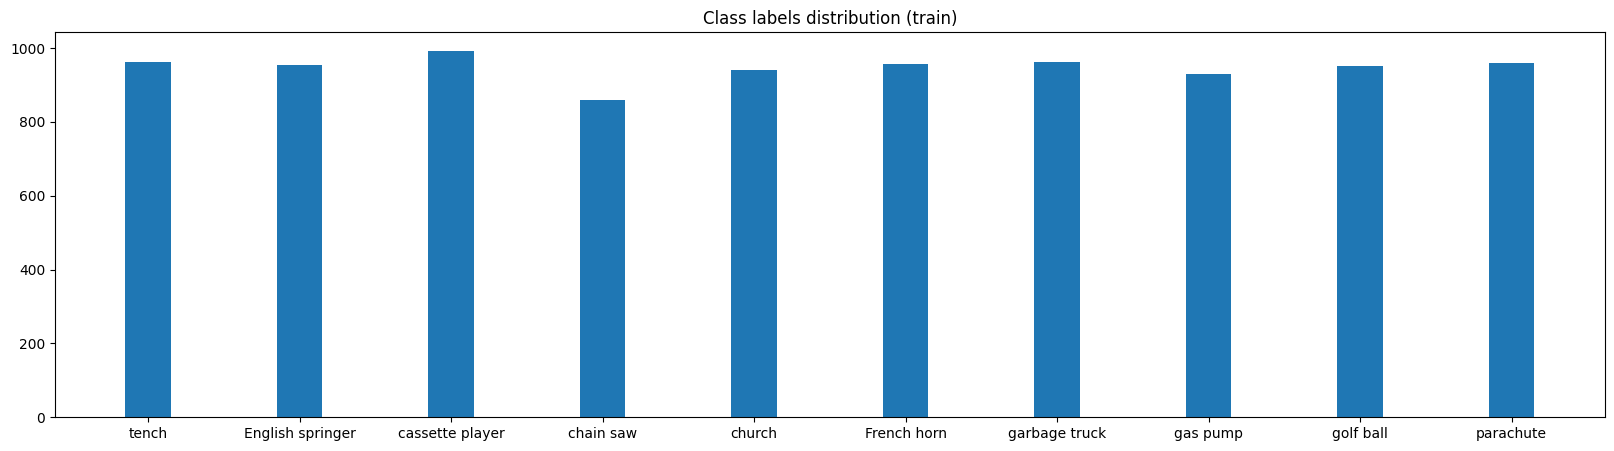

In [5]:
### Description ###

# Number of samples for each set
print("Number of train samples: ", len(imagenette_train))
print("Number of test samples: ", len(imagenette_test))

# Class labels
label_names = [cls[0] for cls in imagenette_train.classes]
print(f"\nClass labels: {label_names}\n")

# Class labels distribution
labels = [label for _, label in imagenette_train]
_, counts = np.unique(labels, return_counts=True)
label_counts = dict(zip(label_names, counts.data))

# Plotting the distribution
plt.figure(figsize=(20, 5))
plt.bar(label_counts.keys(), label_counts.values(), width=0.3)
plt.title("Class labels distribution (train)")
plt.show()

The plot shows the number of samples from each class is similar, the only one that stands out to us is chain saw which is lower than the others but not by that much(relatively), so we think the classes are balanced.

# EX2 - Pretrained models (20pts)

1. Choose 2 models from ```torchvision.models``` ([link](https://pytorch.org/vision/stable/models.html)) that were pretrained on ImageNet. The third model is one of ResNet18/34/50 (the other models can't other ResNet variation).
2. Use ```torch-summary``` to summarize each model for an input of shape ```1x3x224x224```.
3. Describe each model in 2-4 lines. Think carefully what information might be relevant for this homework assignment (see EX3-EX4). It is recommended to read the paper in which each model was first presented but it is not required. You are, however, required to go over model's description in torchvision documentation (see the information tab for ResNet18 for an example [link](https://pytorch.org/vision/0.19/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18) )
4. Summarize the similarities and difference between the 3 models.

## ConvNext-Tiny

In [6]:
### ConvNext-Tiny Summary ###

summary(models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1), input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "kernel_size", "num_params"])


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:01<00:00, 82.2MB/s]


Layer (type:depth-idx)                        Input Shape               Output Shape              Kernel Shape              Param #
ConvNeXt                                      [1, 3, 224, 224]          [1, 1000]                 --                        --
├─Sequential: 1-1                             [1, 3, 224, 224]          [1, 768, 7, 7]            --                        --
│    └─Conv2dNormActivation: 2-1              [1, 3, 224, 224]          [1, 96, 56, 56]           --                        --
│    │    └─Conv2d: 3-1                       [1, 3, 224, 224]          [1, 96, 56, 56]           [4, 4]                    4,704
│    │    └─LayerNorm2d: 3-2                  [1, 96, 56, 56]           [1, 96, 56, 56]           --                        192
│    └─Sequential: 2-2                        [1, 96, 56, 56]           [1, 96, 56, 56]           --                        --
│    │    └─CNBlock: 3-3                      [1, 96, 56, 56]           [1, 96, 56, 56]           --  

### Description
ConvNext-Tiny uses Conv2d layers for downsampling, going from 96x56x56 to 192x28x28 to 384x14x14 to a final feature map of 768x7x7, and a final flattened embedding vector of size 768 after global average pooling.
Between the downampling convolutions there are LayerNorms and ConvNext blocks which are composed of 7x7 depthwise convolutions and 2 Linear layers.

## VisionTransformer

In [7]:
### ViT-B/16 Summary ###

summary(models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1), input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "kernel_size", "num_params"])

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 181MB/s]


Layer (type:depth-idx)                        Input Shape               Output Shape              Kernel Shape              Param #
VisionTransformer                             [1, 3, 224, 224]          [1, 1000]                 --                        768
├─Conv2d: 1-1                                 [1, 3, 224, 224]          [1, 768, 14, 14]          [16, 16]                  590,592
├─Encoder: 1-2                                [1, 197, 768]             [1, 197, 768]             --                        151,296
│    └─Dropout: 2-1                           [1, 197, 768]             [1, 197, 768]             --                        --
│    └─Sequential: 2-2                        [1, 197, 768]             [1, 197, 768]             --                        --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             [1, 197, 768]             --                        7,087,872
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             [1, 197, 768]   

### Description
ViT-B/16 uses a 16x16 convolution with 16 stride to split the input image into 16x16 patches, then transforms each patch into tokens of size 768. The 196 tokens are grouped with a cls token in a 197x768 matrix. This matrix is passed as input to 12 Transformer Encoder blocks which are composed of Nomalization, Multi-Head Self-Attention, and 2 Linear layers, and keep the dimensions the same. Classification is done at the end using a Linear layer with the learned cls token as the embedding.

## ResNet18

In [8]:
### ResNet18 Summary ###

summary(models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1), input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "kernel_size", "num_params"], depth=4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 210MB/s]


Layer (type:depth-idx)                   Input Shape               Output Shape              Kernel Shape              Param #
ResNet                                   [1, 3, 224, 224]          [1, 1000]                 --                        --
├─Conv2d: 1-1                            [1, 3, 224, 224]          [1, 64, 112, 112]         [7, 7]                    9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         [1, 64, 112, 112]         --                        128
├─ReLU: 1-3                              [1, 64, 112, 112]         [1, 64, 112, 112]         --                        --
├─MaxPool2d: 1-4                         [1, 64, 112, 112]         [1, 64, 56, 56]           3                         --
├─Sequential: 1-5                        [1, 64, 56, 56]           [1, 64, 56, 56]           --                        --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           [1, 64, 56, 56]           --                        --
│    │    └─Con

### Description
ResNet18 begins with a 7x7 Convolution and continues with 8 BasicBlocks which are composed of 2 groups of 3x3 convolution, BatchNorm and ReLU, sometimes with another 1x1 convolution in the end for downsampling, with skip connections between the blocks. The downsampling ends with a 512x7x7 feature map and after global average pooling we end up with an embedding vector of size 512.

## Model similarities and differences
1. Architecture type - ResNet18 and ConvNext-Tiny are CNN's, while ViT-B/16 is a transformer model that uses self-attention layers instead of convolutional layers
2. Embeddings - All 3 models produce an embedding vector in the end and can be used as a backbone for image classification.
3. Representation - In the ResNet18 and ConvNext-Tiny architectures each block produces a feature map, while the Vit-B/16 produces a token sequence after each Encoder block.
4. Parameters - Vit-B/16 has 86 Million parameters, way more than ResNet18 and ConvNext-Tiny.

# EX3 - Visualizing feature maps (30pts)
In this section you will visualize the feature maps learned by your chosen models.


*   In a convoultion-based models (i.e., ResNet, ConvNext), use the final conv block. If the image resolution is too small do to maxpooling operations, you may choose a different block.
*   In a vision transformer (ViT), use model output without the cls token (if relevant).

Assignments:


1.   Describe the feature map shape for an input image of shape ```1x3x224x224``` (i.e., ```1x512xHxW``` for some model).
2. Choose 1 class from Imagenette and sample 10 random images.
3. Extract the feature maps from each model and perform PCA on the channel dim and reduce it to 3. The output should be of size ```10x3xHxW```
4. Resize the features to 112x112 and plot the images for each model (3 row x 10 columns)
5. Summarize the similarities and difference between the 3 models according to the PCA for the features you have presented.





In [9]:
### 10 random Imagenette images ###

parachute_class_idx = 9  # Parachute class
parachute_images = np.where(np.array(labels) == parachute_class_idx)[0]
random_sample = Subset(imagenette_train, np.random.choice(parachute_images, size=10, replace=False))

In [10]:
def extract_cnn_feature_maps(model, sample):
  model.eval()
  feature_maps = []
  model_backbone = nn.Sequential(*list(model.children())[:-2])  # All model layers except the final pooling and classification layers

  with torch.no_grad():
    for image, _ in sample:
      feature_maps.append(model_backbone(image.unsqueeze(0).to(device)).squeeze(0))

  return feature_maps

In [11]:
def extract_vit_feature_maps(model, sample):
  model.eval()
  feature_maps = []

  with torch.no_grad():
    for image, _ in sample:
      # Forward pass without classification part
      patch_tokens = model._process_input(image.unsqueeze(0).to(device))
      cls_token = model.class_token.expand(patch_tokens.shape[0], -1, -1)
      all_tokens = torch.cat([cls_token, patch_tokens], dim=1)
      output = model.encoder(all_tokens)
      output_without_cls = output[:, 1:, :]

      # Reshape tokens to feature maps - [768, 14, 14]
      B, N, C = output_without_cls.shape
      H = W = int(N ** 0.5)
      feature_map = output_without_cls.transpose(1, 2).reshape(B, C, H, W)
      feature_maps.append(feature_map.squeeze(0))

  return feature_maps

In [12]:
def pca_on_channels(feature_maps):
  pca_feature_maps = []

  for feature_map in feature_maps:
      C, H, W = feature_map.shape
      reshaped_map = feature_map.permute(1, 2, 0).reshape(H * W, C).detach().cpu().numpy()  # Reshaping to (H * W, C)

      pca = PCA(n_components=3)
      pca_result = pca.fit_transform(reshaped_map)

      pca_result_reshaped = pca_result.reshape(H, W, 3).transpose(2, 0, 1)  # Reshaping back to (3, H, W)
      pca_feature_maps.append(torch.from_numpy(pca_result_reshaped))

  pca_feature_maps = torch.stack(pca_feature_maps)
  return pca_feature_maps

In [13]:
### Loading the models ###

resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).to(device)
convnext_tiny = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1).to(device)
vit_b_16 = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1).to(device)

In [14]:
### Feature map shapes ###

input = [random_sample[0]]
resnet_output = extract_cnn_feature_maps(resnet18, input)
convnext_output = extract_cnn_feature_maps(convnext_tiny, input)
vit_output = extract_vit_feature_maps(vit_b_16, input)

print("Feature map shapes for input image of shape 1x3x224x224:\n")
print("ResNet18 - ", list(resnet_output[0].shape))
print("ConvNext - ", list(convnext_output[0].shape))
print("ViT-B/16 - ", list(vit_output[0].shape))

Feature map shapes for input image of shape 1x3x224x224:

ResNet18 -  [512, 7, 7]
ConvNext -  [768, 7, 7]
ViT-B/16 -  [768, 14, 14]


In [15]:
### Extracting feature maps for the 10 images ###

resnet_feature_maps = extract_cnn_feature_maps(resnet18, random_sample)
convnext_feature_maps = extract_cnn_feature_maps(convnext_tiny, random_sample)
vit_feature_maps = extract_vit_feature_maps(vit_b_16, random_sample)

In [16]:
### Applying PCA on the channel dim ###

resnet_feature_maps = pca_on_channels(resnet_feature_maps)
convnext_feature_maps = pca_on_channels(convnext_feature_maps)
vit_feature_maps = pca_on_channels(vit_feature_maps)

In [17]:
### Resizing feature maps to 112x122 ###

resnet_feature_maps = nn.functional.interpolate(resnet_feature_maps, size=(112, 112))
convnext_feature_maps = nn.functional.interpolate(convnext_feature_maps, size=(112, 112))
vit_feature_maps = nn.functional.interpolate(vit_feature_maps, size=(112, 112))

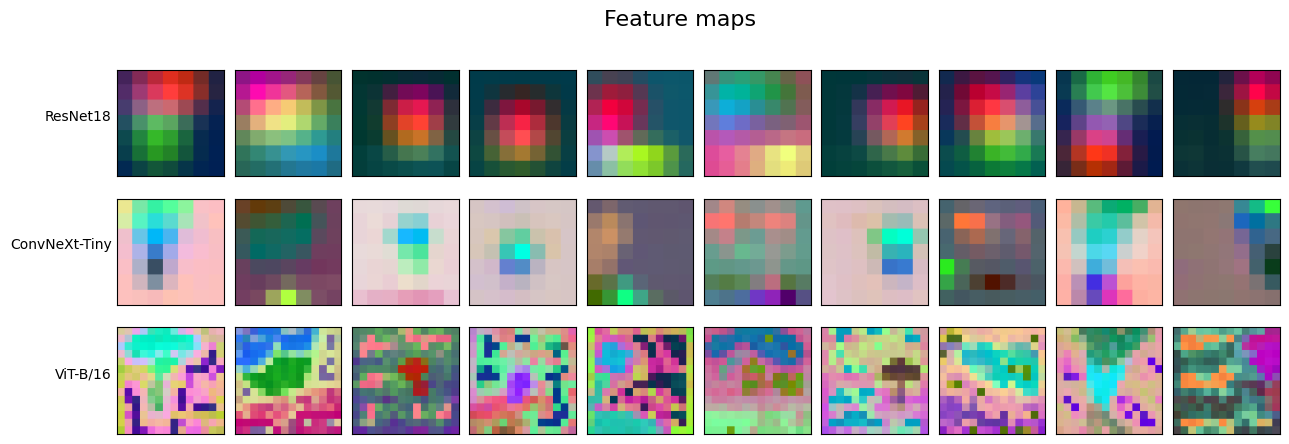

In [18]:
### Plotting the feature maps ###

fig, axs = plt.subplots(3, 10, figsize=(15, 5))
plt.suptitle("Feature maps", fontsize=16)
plt.subplots_adjust(wspace=0.1, hspace=0.01)

for i, (r, c, v) in enumerate(zip(resnet_feature_maps, convnext_feature_maps, vit_feature_maps)):
  for j, feature_map in enumerate([r, c, v]):
    # Normalizing the feature maps between 0 and 1
    min_val = feature_map.min()
    max_val = feature_map.max()
    if max_val == min_val:
        normalized_feature_map = torch.zeros_like(feature_map)
    else:
        normalized_feature_map = (feature_map - min_val) / (max_val - min_val)

    # Plotting the normalized feature maps
    axs[j, i].imshow(normalized_feature_map.permute(1, 2, 0).cpu().numpy())
    axs[j, i].set_xticks([])
    axs[j, i].set_yticks([])


axs[0,0].set_ylabel('ResNet18', rotation='horizontal', ha='right')
axs[1,0].set_ylabel('ConvNeXt-Tiny', rotation='horizontal', ha='right')
axs[2,0].set_ylabel('ViT-B/16', rotation='horizontal', ha='right')

plt.show()

### Summary

It's very clear from looking at the feature maps that the ResNet18 and ConvNext-Tiny feature maps look similar, probably meaning that they learned similar features and this makes sense because they are both convolutional networks that were trained on the same data.
Also, both of the ResNet18 and ConvNext-Tiny feature maps look simple, probably meaning that the features they learned were not too complex, as opposed to the ViT-B/16 features which look very complex, and this makes sense because the self-attention mechanism learns relationships between different and far away parts of the image, and learns a more complex representation of the data this way.

# EX4 - K-Nearest Neighbors (KNN) in the Embedding Space (50pts)
Also know ans "few-shot/ Zero-shot learning".
Perform KNN classification using the feature vectors from each of the 3 models between the train and test set of Imagenette.


## Visualizing the embedding layer distribution.
* Write an ```extract_embedding(dataloader, model, model_name)``` function that takes in a dataloader and a model and return the ```N x Num_features``` matrix for that set. Make sure that shuffle is off.
* You may write different condition for different models. I.e., the embedding in a ViT model is the ```CLS``` token.

* Plot the t-SNE of the train set for each of the 3 models. Color label the points according to the class labels (see t-SNE implementation by sklearn).

* Write a 2-3 lines disscussion about the data distribution of each model and their comparison.


## Build a KNN ```class``` with the following methods:


*   ```init()```: takes the num_classes and other useful information.
* ```extract_embedding(X, model)```: Extracts the embedding vector for the entire train set using the model. X_features should be ```Nxnum_ft```. Call the function from the previous section.

*   ```fit(X_train, y_train, model)```: Extracts the embedding vector for the entire train set using the ```extract_embedding()``` method and stores it as ```self.X_train_ft``` and ```self.y_labels``` (the labels from the train set).  


*   ```predict(X_test, model, n_neighbors)```: Extracts the embedding vector for the entire train set using the ```extract_embedding()``` method and performs KNN for a given K. Returns the predicted_labels.
* ```compute_accuracy(y_true, y_pred)```.


## Compare the KNN accuracy
using each of the 3 models for $K\in[1,3,5 ]$ and report the results in a table or a graph. Summarize the results in 2-4 lines.


In [19]:
### Extract embedding function ###

def extract_embedding(dataloader, model, model_name):
  feature_mat = []
  with torch.no_grad():
    for images, labels in tqdm(dataloader):
      images = images.to(device)
      if model_name == "ViT-B/16":
        model.eval()
        patch_tokens = model._process_input(images)
        cls_token = model.class_token.expand(patch_tokens.shape[0], -1, -1)
        all_tokens = torch.cat([cls_token, patch_tokens], dim=1)
        output = model.encoder(all_tokens)
        cls_embedding = output[:, 0, :].cpu()
        feature_mat.append(cls_embedding)
      else:
        model_backbone = nn.Sequential(*list(model.children())[:-1])
        model_backbone.eval()
        output = model_backbone(images)
        embedding = output.flatten(1).cpu()
        feature_mat.append(embedding)

  feature_mat = torch.cat(feature_mat, dim=0)
  return feature_mat

In [20]:
### Extracting embeddings for each model ###

vit_embeddings = extract_embedding(train_loader, vit_b_16, "ViT-B/16")
resnet_embeddings = extract_embedding(train_loader, resnet18, "ResNet18")
convnext_embeddings = extract_embedding(train_loader, convnext_tiny, "ConvNext-Tiny")

100%|██████████| 37/37 [00:50<00:00,  1.36s/it]


In [21]:
### Performing t-SNE on each model's embeddings ###

tsne = TSNE(n_components=2, random_state=42)

tsne_vit = tsne.fit_transform(vit_embeddings.numpy())
tsne_resnet = tsne.fit_transform(resnet_embeddings.numpy())
tsne_convnext = tsne.fit_transform(convnext_embeddings.numpy())

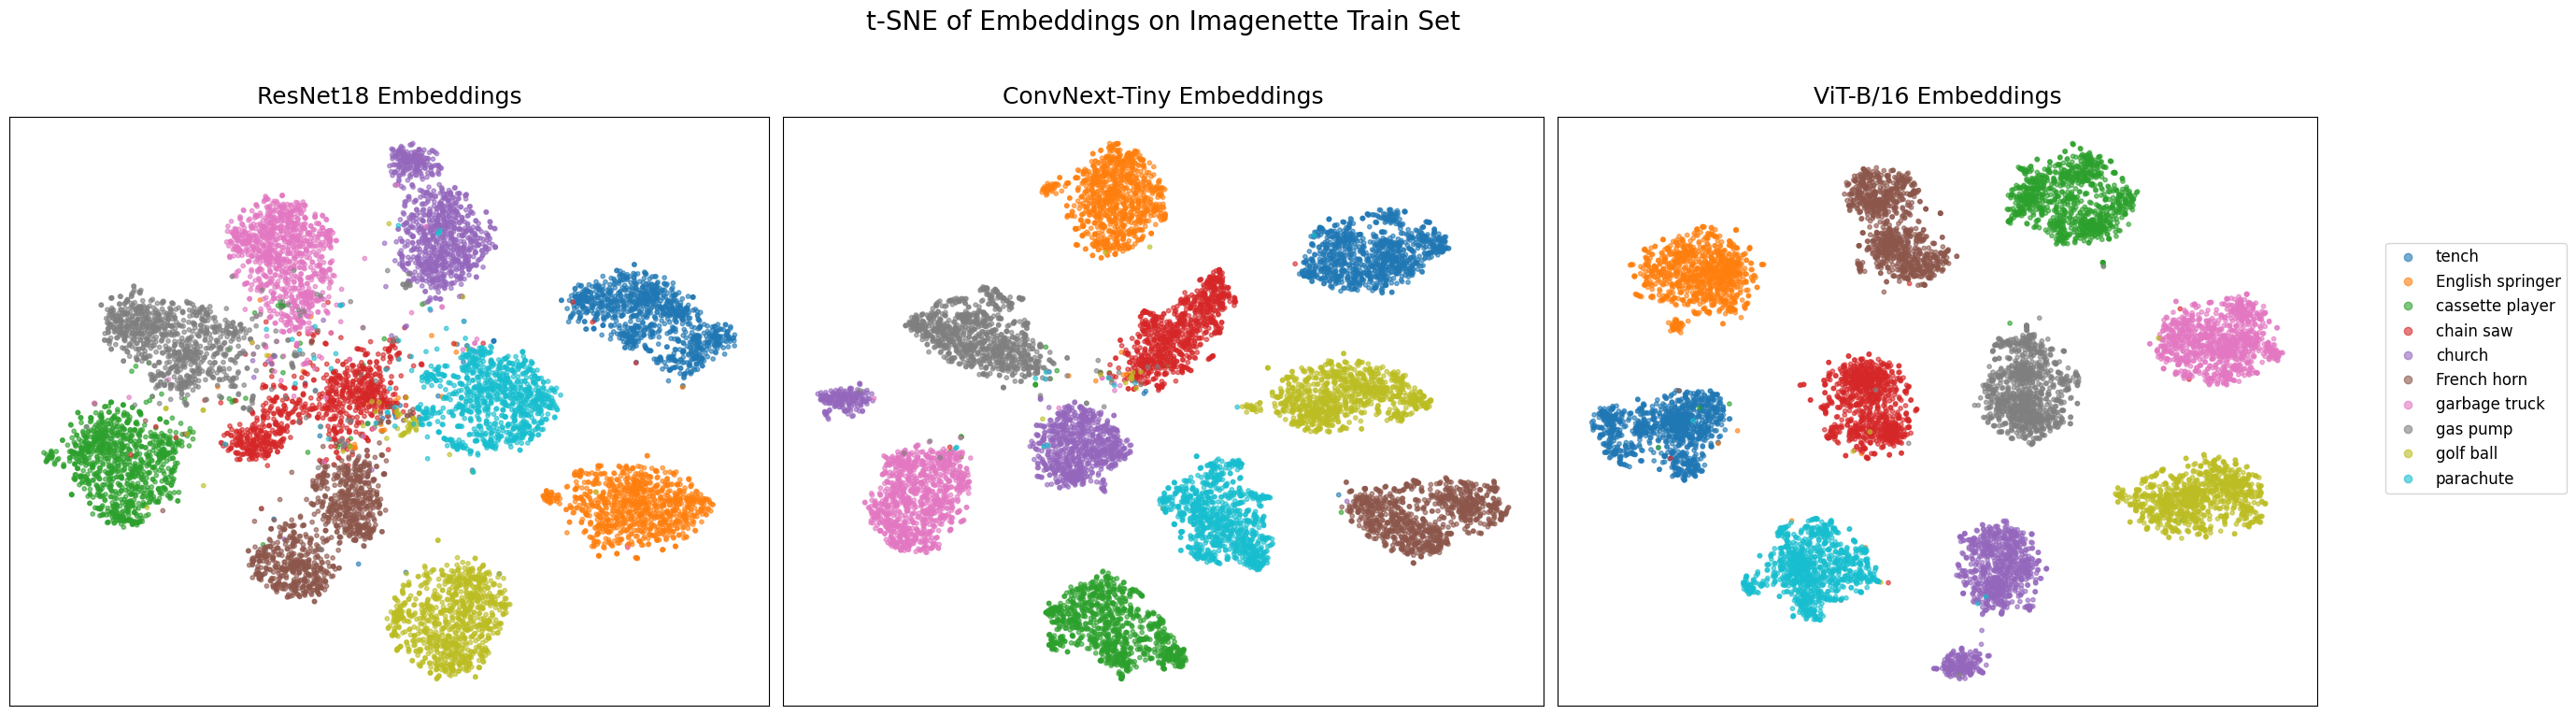

In [22]:
### Plotting the t-SNE's for each model ###

def plot_tsne(tsne_embeddings, labels, model_name, axes):
    plot = axes.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=labels, cmap='tab10', s=10, alpha=0.6)
    axes.set_title(model_name + ' Embeddings', fontsize=18, pad=10)
    axes.set_xticks([])
    axes.set_yticks([])
    return plot

class_names = imagenette_train.classes

fig, axes = plt.subplots(1, 3, figsize=(25, 8)) # 1 row, 3 columns
fig.suptitle('t-SNE of Embeddings on Imagenette Train Set', fontsize=20)

resnet_plot = plot_tsne(tsne_resnet, labels, "ResNet18", axes[0])
convnext_plot = plot_tsne(tsne_convnext, labels, "ConvNext-Tiny", axes[1])
vit_plot = plot_tsne(tsne_vit, labels, "ViT-B/16", axes[2])

handles, _ = resnet_plot.legend_elements()
legend_labels = [name[0] for name in class_names]

# Create the figure-level legend on the right
legend = fig.legend(handles, legend_labels, bbox_to_anchor=(1.02, 0.5), loc='center left', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Discussion

First of all it seems that for all 3 model the classes in the data have a good seperation - most points from each class appear together in a blob and are not too mixed up with different classes. In terms of seperation quality, for us it is obvious that the ResNet18 model has the worst seperation because the class blobs are closer together and for some classes there are a lot of points that landed far away from the class blob, the ConvNext-Tiny model has a better seperation and the ViT-B/16 model has the best seperation.

In [23]:
### KNN classifier ###

class KNN():
  def __init__(self, num_classes, device):
    self.num_classes = num_classes
    self.device = device
    self.X_train_ft = None
    self.y_labels = None


  def extract_embedding(self, dataloader, model, model_name):
    return extract_embedding(dataloader, model, model_name)


  def fit(self, X_train, y_train, model, model_name):
    if not isinstance(y_train, torch.Tensor):
      self.y_labels = torch.tensor(y_train)
    else:
      self.y_labels = y_train

    self.X_train_ft = self.extract_embedding(X_train, model, model_name)


  def predict(self, X_test, model, model_name, n_neighbors):
    X_test_ft = self.extract_embedding(X_test, model, model_name).to(self.device)
    X_train_ft = self.X_train_ft.to(self.device)

    # Calculate Euclidean distances between test embeddings and train embeddings
    distances = torch.cdist(X_test_ft, X_train_ft, p=2)

    # Find the k-nearest neighbors for each test sample
    _, indices = torch.topk(distances, k=n_neighbors, dim=1, largest=False)

    # Get the labels of the k-nearest neighbors
    neighbor_labels = self.y_labels[indices.cpu()]

    # For each test sample count occurrences of each class in neighbor_labels
    # and take the class with max occurences
    predicted_labels = torch.empty(X_test_ft.shape[0], dtype=torch.int64)
    for i in range(X_test_ft.shape[0]):
      unique_labels, counts = torch.unique(neighbor_labels[i], return_counts=True)
      predicted_labels[i] = unique_labels[torch.argmax(counts)]

    return predicted_labels


  def compute_accuracy(self, y_true, y_pred):
    accuracy = torch.mean((y_true == y_pred).float()).item()
    return accuracy

In [24]:
### Running KNN on each model for K = [1,3,5]

def run_knn(knn, loader, labels, model, model_name):
  predictions = []
  knn.fit(train_loader, labels, model, model_name)
  for k in [1, 3, 5]:
    y_pred = knn.predict(loader, model, model_name, k)
    predictions.append(y_pred)

  return predictions


y_true = torch.tensor([label for _, label in imagenette_test], dtype=torch.int64)

knn = KNN(len(label_names), device)

resnet_predictions = run_knn(knn, test_loader, labels, resnet18, "ResNet18")
convnext_predictions = run_knn(knn, test_loader, labels, convnext_tiny, "ConvNext-Tiny")
vit_predictions = run_knn(knn, test_loader, labels, vit_b_16, "ViT-B/16")

resnet_accuracies = [knn.compute_accuracy(y_true, resnet_predictions[i]) for i in range(3)]
convnext_accuracies = [knn.compute_accuracy(y_true, convnext_predictions[i]) for i in range(3)]
vit_accuracies = [knn.compute_accuracy(y_true, vit_predictions[i]) for i in range(3)]

results = pd.DataFrame({
    'Model': ['ResNet18', 'ConvNext-Tiny', 'ViT-B/16'],
    'K=1': [resnet_accuracies[0], convnext_accuracies[0], vit_accuracies[0]],
    'K=3': [resnet_accuracies[1], convnext_accuracies[1], vit_accuracies[1]],
    'K=5': [resnet_accuracies[2], convnext_accuracies[2], vit_accuracies[2]]
})

print(results)


100%|██████████| 16/16 [00:50<00:00,  3.13s/it]


           Model       K=1       K=3       K=5
0       ResNet18  0.953885  0.958471  0.962803
1  ConvNext-Tiny  0.989299  0.991338  0.992357
2       ViT-B/16  0.994904  0.995159  0.993885
